# Bridging the gap between teaching and doing quant finance

Quantitative finance is a broad term, here I am referring to solving pricing problems in the capital markets space (with all their regulatory and other side effects).

There are a lot of things that a student and practitioner need to know as a quant.

I am going to explore the possibilty of creating a quant library that
 * Meets the requirements of a bank to solve pricing problems
 * Has a close link to the fundamental maths concepts so that it can be used for teaching
 
Put differently
 * It is fast and easy to use for actual products
 * You can find $(\Omega, \mathcal{F}, \mathbb{Q})$ and $\mathbb{E}^{\mathbb{Q}}\left[ H(T) \middle| \mathcal{F}_T \right]$ in the code



# Teaching

When we teach we are aiming to get students to:

 * Work with SDEs
 * Understand measure changes and risk neutrality
 * See contingent claims as random variables
 * Evaluate expectations of these random variables
 * Learn supporting numerical techniques to evaluate these expectations
 
---

# Doing

When we do quant work we are aiming to

 * Understand a contract and business's cashflows in all states of the world
 * Select a model that realisically captures the uncertainty of those states of the world
 * Calibrate the model to a cross section of prices
 * Provide the model user with an easy way to get the fair present value and sensitivities of these cashflows
 
---

# Overlap

Unfortunately these two lists do not have a lot of overlap.

Often we do make some effort to explicity teach the cashflows for a particular contingent claim, usually for the purpose of deriving some clever closed form price for it or demonstrating

I am going to propose a setup that links the teaching and doing regions via a pedagogical smooth pasting condition.

Furthermore a key point of the "Doing" section is about delivering working software to the consumers of the models.  Of course not every quant wants to nor needs to be a software developer but the organiation where they work must provide a mechanism of getting their models into working software.

This proposal also gets quant students to learn inside a pre-existing software architecture, getting used to this early on and then being able to bring their studying development directly into the work environment.

---

# Setting up an Economy

We assume that we have:
 
 * a final time $T$
 * a probability space, a filtration and a measure: $(\Omega, \mathcal{F}, \mathbb{Q})$
 * stochastic processes: $\textbf{W}(t)$  (not neccessarily Brownian motions notwithstanding the use of $W$)
 * a numeraire asset $N(t)$ which is a function of $\textbf{W}(t)$, and
 * $K$ market observables are labeled $S_1(t),...S_K(t)$ which are also all functions of $\textbf{W}(t)$
   * these are not neccessarily all tradable assets.  They could be things like forward rates or a default indicators

We further assume that the measure $\mathbb{Q}$ is already the risk neutral one so that for any tradable asset $P$ (see later) with cashflows only at $T$ we have

$$ \frac{P(t)}{N(t)} = \mathbb{E}^\mathbb{Q} \left[ \frac{P(T)}{N(T)} \middle| \mathcal{F}(t) \right] $$

---

# Tradable Assets

The cashflows on any product or portfolio take place at fixed times and are calculated as functions of the $K$ market observables.  In general if there is a cashflow at $u_i$ it will depend on market observables at times on or before $u_i$

$$ X_i = f(S_{j_0}(v_{k_0}), S_{j_1}(v_{k_1}), ...) $$

with $(j_l, k_l)$ in some set $\mathcal{J}(u_i)$ that depends on the product and $u_i$; and $v_{k_l} \leq u_i$

The value of any product at $t_0$ is then:

$$ V(t_0) =  \mathbb{E}^\mathbb{Q} \left[ \sum_{u_i>t_0}{\frac{S_{xn}(u_i)X_i}{N(u_i)}} \right] $$

Where $N(u_i)$ is the numeraire in the value currency and $S_{xn}$ is that market observable that converts units of the cashflow currency into units of the numeraire currency, i.e. the exchange rate.

Any product without optionality can then be represented by the set of random variables and the times at which the cashflows represented by the random variables take place:

$$ P = \left\{ \left(X_1, u_1\right), ..., \left(X_M, u_M\right) \right\} $$

---

# Link to Doing

This all seems more like teaching quant finance rather than doing quant finance.

What do the $S$ look like and what does a $P$ look like?

The types of $S$ that exist in QuantSA are:
 * CurrencyPair
 * DefaultRecovery
 * DefaultTime
 * Dividend
 * FloatingIndex
 * Share

And each of these has a specific type, CurrencyPair will have a base and counter currency, DefaultTime will have a company and default type and FloatingIndex will be one of the world's named floating indices such as 3 month Jibar.

The specific type of each of these has a value that can be observed on a screen at a time.

The cashlows on a product can be written as functions of these observables.

---


## Example FRA
The cashflow on a South African FRA depends only on 3m Jibar, say $S_0$, observed on a single date $u_1$, a fixed rate $K$ and an accrual fraction $\Delta t$:

$$ P_{FRA} = \left\{ \left( (S_0(u_1)-K) \Delta t \frac{1}{1+ S_0(u_1) \Delta t} , u_1 \right) \right\}$$


## Example Equity Call Option
The cashflow on a cash settled equity call option with exercise date $u_1$ on a single share, say $S_1$, with stike $K$:

$$ P_{CALL} = \left\{ \left( \max(S_1(u_1)-K,0), u_1 \right) \right\}$$

---

# Implementing a Product

We have seen the maths of how products are defined, now let us see how to implement it.

## Example code FRA
```cs
Date date = new Date(2017, 08, 28);
FloatingIndex jibar = FloatingIndex.JIBAR3M;
double dt = 91.0/365.0;
double fixedRate = 0.071;
double notional = 1000000.0;
Currency currency = Currency.ZAR;

public override List<Cashflow> GetCFs()
{
    double reset = Get(jibar, date);
    double cfAmount = notional * (reset - fixedRate)*dt/(1+dt*reset);
    return new List<Cashflow>() { new Cashflow(date, cfAmount, currency) };
}
```

## Example code Call

```cs
Date exerciseDate = new Date(2017, 08, 28);
Share share = new Share("AAA", Currency.ZAR);
double strike = 100.0;

public override List<Cashflow> GetCFs()
{
    double amount = Math.Max(0, Get(share, exerciseDate) - strike);
    return new List<Cashflow>() {new Cashflow(exerciseDate, amount, share.currency) };        
}
```

This is a little bit like the Portfolio Aggregarion Language (PAL) in Cesari *et al* (2010).  But the vocabulary is smaller, the syntax is straight C#, and there is no information other than what would be contained in the trade confirmation sheet.

As you can see we have "learnt" exactly what a FRA and a call option are in a completely model independent way.

The next step is to look at how to value these products.

---

# Examples of using the Library

## Technicalities

The library is written in C#.  There are many reasons why this makes sense:
 * It is a type-safe, object-oriented language - good for building and maintaining large code bases.
 * It is easier to learn and write than C++
 * It is faster than Python or Matlab
 * It is even becoming portable
 * It plays nicely with the typical bank employee's Microsoft Windows and Office environment
 
Nevertheless Python (or Matlab) remain much more convenient for scientific computing where you are experimenting with different models and methods.

To use QuantSA from Python we need the following:

In [26]:
import clr # to be able to use the C# library

clr.AddReference("System.Collections")
clr.AddReference(r'C:\Dev\QuantSA\QuantSA\Valuation\bin\Debug\QuantSA.General.dll')
clr.AddReference(r'C:\Dev\QuantSA\QuantSA\Valuation\bin\Debug\QuantSA.Valuation.dll')

from System.Collections.Generic import List
from QuantSA.General import *
from QuantSA.Valuation import *
print("The library is ready to use!")

The library is ready to use!


## Make a product

In [27]:
source = """Date date = new Date(2017, 8, 28);
FloatingIndex jibar = FloatingIndex.JIBAR3M;
double dt = 91.0/365.0;
double fixedRate = 0.071;
double notional = 1000000.0;
Currency currency = Currency.ZAR;

public override List<Cashflow> GetCFs()
{
    double reset = Get(jibar, date);
    double cfAmount = notional * (reset - fixedRate)*dt/(1+dt*reset);
    return new List<Cashflow>() { new Cashflow(date, cfAmount, currency) };
}
"""
# Make a product at runtime
fra = RuntimeProduct.CreateFromString("MyFRA", source);
print("Now we have a FRA:")
print(fra)


Now we have a FRA:
MyFRA


## Make a model

In [28]:
# Set up the model
valueDate = Date(2016, 9, 17)
maximumDate = Date(2026, 9, 17)
dates = [Date(2016, 9, 17) , Date(2026, 9, 17)]

rates = [ 0.07, 0.07 ]
discountCurve = DatesAndRates(Currency.ZAR, valueDate, dates, rates, maximumDate)
numeraireModel = DeterminsiticCurves(discountCurve);
otherModels = List[Simulator]() # no model other than discounting for now.
coordinator = Coordinator(numeraireModel, otherModels, 1) # the magic ingredient that gets models and products to work together
print("A model is ready.")

A model is ready.


## Value the product with the model

In [29]:
# Run the valuation
portfolio = [fra]
value = coordinator.Value(portfolio, valueDate)

IndexOutOfRangeException: Required index: ZAR:JIBAR:3M is not provided by any of the simulators.
   at QuantSA.Valuation.Coordinator.AssociateFactorsWithSimulators(List`1 portfolio) in C:\Dev\QuantSA\QuantSA\Valuation\Coordinator.cs:line 585
   at QuantSA.Valuation.Coordinator.CalculateAll(Product[] portfolioIn, Date valueDate, Date[] fwdValueDates) in C:\Dev\QuantSA\QuantSA\Valuation\Coordinator.cs:line 426
   at QuantSA.Valuation.Coordinator.Value(Product[] portfolioIn, Date valueDate) in C:\Dev\QuantSA\QuantSA\Valuation\Coordinator.cs:line 503

Aha, this is good.  You can't value a FRA with a discounting model because its cashflow depends on 3 month Jibar and your model does not know anything about 3 month Jibar.

With this type of constraint:

 * You will never work under the wrong numeraire again
 * You will never use the wrong curve to forecast a rate
 
So we need to fix the model by setting it up to forecast some rates:

In [30]:
# add a forecast curve
forecastCurve = ForecastCurve(valueDate, FloatingIndex.JIBAR3M, dates, rates) # use flat 7% rates for forecasting
numeraireModel.AddRateForecast(forecastCurve) # add the forecast curve to the model

# value the product
portfolio = [fra]
value = coordinator.Value(portfolio, valueDate)

# check the value
import numpy as np
date = Date(2017, 8, 28)
t = (date.value - valueDate.value) / 365.0 # C# operator overloading does not work in Python
dt = 91.0 / 365.0
fixedRate = 0.071
notional = 1000000.0
fwdRate = 0.07
refValue = notional * (fwdRate - fixedRate) * dt / (1 + fwdRate * dt) * np.exp(-t * 0.07);

print("value is: {:.2f}.  Expected {:.2f}".format(value, refValue))

value is: -229.35.  Expected -229.35


# Future Values

In addition to the cashflows on a product that are explcitly defined by the bilateral contract, there are many other financial effects of trading a product such as:

 1. The need to fund the cashflows
 1. The capital required to be held against the position
 1. The loss in the event the counterparty default
 1. The need to place collateral and fund that collateral position
 1. The gain in the event that we default ourselves !?!?!
 
In general these depend on the bank's fair value of these products at future dates

---

In [31]:
# Set up the swap
rate = 0.08
payFixed = True
notional = 1000000
startDate = Date(2016, 9, 17)
tenor = Tenor.Years(5)
swap = IRSwap.CreateZARSwap(rate, payFixed, notional, startDate, tenor)
print("Now we have a swap:")
print(swap)

Now we have a swap:
QuantSA.General.IRSwap


In [45]:
# Set up the model
valueDate = Date(2016, 9, 17)
a = 0.05
vol = 0.01
flatCurveRate = 0.07
hullWiteSim = HullWhite1F(a, vol, flatCurveRate, flatCurveRate, valueDate)
hullWiteSim.AddForecast(FloatingIndex.JIBAR3M)
hwCoordinator = Coordinator(hullWiteSim, List[Simulator](), 5000)

print("A stochastic rate model is ready (Hull White).")

A stochastic rate model is ready (Hull White).


In [46]:
# Get the simulated forward values and the regressors used to obtain them
from datetime import datetime
from datetime import timedelta
step = timedelta(days=10)
# make the forward dates on which the values are required
pyDates = []
date = datetime(2016, 9, 17)
endDate = datetime(2021,9,17)
while date<endDate:
    date += step
    pyDates.append(date)
csDates = [Date(d.year, d.month, d.day) for d in pyDates]
valuePaths = hwCoordinator.GetValuePaths([swap], valueDate, csDates);

In [49]:
for s in valuePaths.GetNames():
    print(s)

fwdCashflowPVs
regressedFwdsPVs
regressor0


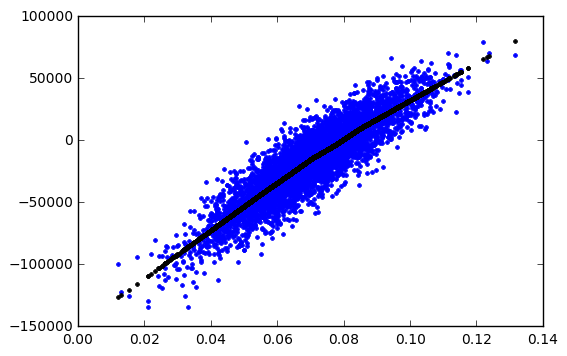

In [69]:
fwdCashflowPVs = valuePaths.Get("fwdCashflowPVs")
regressor0 = valuePaths.Get("regressor0")
regressedFwdsPVs = valuePaths.Get("regressedFwdsPVs")
rawCFVals = np.zeros((5000,))
fwdVals = np.zeros((5000,))
r = np.zeros((5000,))
for i in range(5000):
    rawCFVals[i] = fwdCashflowPVs[i,100]
    fwdVals[i] = regressedFwdsPVs[i,100]
    r[i] = regressor0[i,100]
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(r, rawCFVals,'.')
plt.plot(r, fwdVals,'k.')

# Stopping Times

Stopping times in quant finance are not complicated stochastic control problems

The only exercise decisions that I have ever seen involve deciding to exercise or not at a set of dates.  Always if one exercises one knows what the cashflows are as functions of states of the world and similarly if one does not exercise.

The optimal stopping time for the person who owns this right is the one that chooses the alternative with the higher expected value.

---

# Notes

Will still teach 
 * measure change 
 * Getting closed form prices in HW and Black
 * How to build trees and 
 * How to derive and solve PDEs

Hoping that many parts of quant finance can become like optimization, we all learn how to do it but we use a standard implementation.

For some reason quant finance still has these "black box" fears and "first principles" misconceptions.  

Black boxes are seldom have so little light that it is  impossible to essentially prove that they work the way they are meant to

And first principles gives a good grounding for learning and understanding problems but it is a waste of humankind's productive capacity to do everything from first principles.  also the line between things that one is willing to take for granted (a computer's pseudo random number generator) and the things that one wants to do from first principles (type the equation for $S_0 exp((r-0.5\sigma^2) \Delta T + \sigma \sqrt{\Delta T} Z)$ into Excel) is arbitrary.

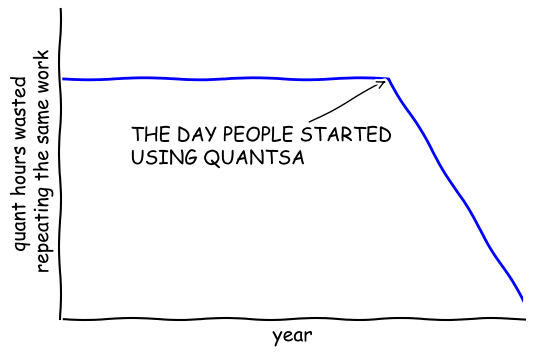

In [36]:
import numpy as np
plt.xkcd()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.xticks([])
plt.yticks([])
ax.set_ylim([-30, 10])

data = np.ones(100)
data[70:] -= np.arange(30)

plt.annotate(
    'THE DAY PEOPLE STARTED\nUSING QUANTSA',
    xy=(70, 0.9), arrowprops=dict(arrowstyle='->'), xytext=(15, -10))

plt.plot(data)

plt.xlabel('year')
plt.ylabel('quant hours wasted \n repeating the same work')
plt.show()

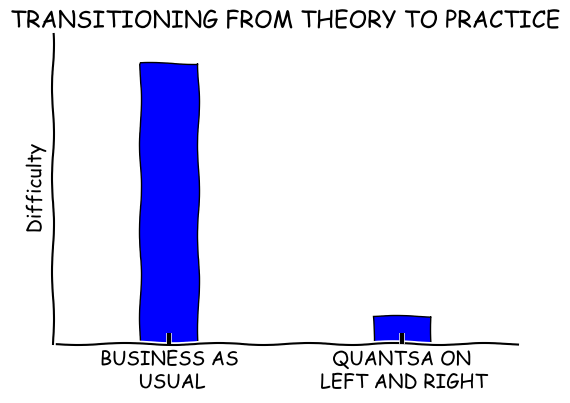

In [37]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar([-0.125, 1.0-0.125], [100, 10], 0.25)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks([0, 1])
ax.set_xlim([-0.5, 1.5])
ax.set_ylim([0, 110])
ax.set_xticklabels(['BUSINESS AS\n USUAL', 'QUANTSA ON \n LEFT AND RIGHT'])
plt.yticks([])
plt.ylabel('Difficulty')
plt.title("TRANSITIONING FROM THEORY TO PRACTICE")

plt.show()

# References

[1] Serguei Issakov Alexandre Antonov and Serguei Mechkov. Backward induction for future values.
*Risk*, pages 92-97, 2015.

[2] G. Cesari, J. Aquilina, and N. Charpillon. *Modelling, Pricing, and Hedging Counterparty Credit
Exposure*. Springer, 2010.

[3] Francis A. Longstaff and Eduardo S. Schwartz. Valuing american options by simulation: A
simple least-squares approach. *Review of Financial Studies*, pages 113-147, 2001.

[4] S.E. Shreve. *Stochastic Calculus for Finance II: Continuous-Time Models.* Number v. 11 in
Springer Finance Textbooks. Springer, 2004.